This notebook can be used to analyse a MSE model




In [1]:
# Some setup code for imports
import os
import sys
import math
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_datasets.BayesRiskDatasetLoader import BayesRiskDatasetLoader


In [2]:

# First we will load the validation set with the calculated scores.
utility = 'unigram-f1'
dataset_loader = BayesRiskDatasetLoader("validation_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral', utility=utility )
validation_dataset = dataset_loader.load(type="pandas")


In [3]:
import numpy as np
def calculate_mbr_scores(entry):
    scores = []
    count = np.sum(entry["utilities_count"])
    for hyp, util in zip(entry["hypotheses"], entry["utilities"]):
        score = np.sum(util * entry["utilities_count"])/count
        scores.append(score)
    return scores

In [4]:
### Next up we will read the trained model and calculate the score given by the heads
from models.pl_predictive.PLPredictiveModelFactory import PLPredictiveModelFactory

model_name = "MSE"
duplicate_hypotheses = False
path = '../../results/{}/{}'.format(model_name, utility)
model_path = "C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/"+ model_name + '/' + utility + '/'
model_scores_path = model_path + 'predicted_scores.parquet'

model, factory = PLPredictiveModelFactory.load(model_path)
model = model.eval()

C:\Users\gerso\FBR\NMT/tatoeba-de-en/model
{'lr': 1.4815897489348615e-05, 'weight_decay': 1.001726887106992e-06, 'loss_function': 'MSE', 'preprocess_type': 'full', 'model_type': 'cross_attention', 'cross_attention_layers': {'n_heads': 4, 'hidden_dim': 512, 'cross_attention': [['decoder_hidden_state_-1', 'encoder_hidden_state_-1'], ['encoder_hidden_state_-1', 'decoder_hidden_state_-1'], ['decoder_hidden_state_-1', 'decoder_hidden_state_-1'], ['encoder_hidden_state_-1', 'encoder_hidden_state_-1']]}, 'query_layers': {'n_queries': 2, 'n_heads': 4, 'hidden_dim': 512}, 'dropout': 0.6712665889822903, 'features': {'decoder_hidden_state': [-1], 'encoder_hidden_state': [-1]}, 'nmt_model': {'model': {'name': 'Helsinki-NLP/opus-mt-de-en', 'checkpoint': 'NMT/tatoeba-de-en/model', 'type': 'MarianMT'}}, 'activation_function': 'silu', 'activation_function_last_layer': 'sigmoid', 'predictive_layers': [4096, 2048, 1024, 512, 1], 'optimizer': 'adam', 'feature_names': ['decoder_hidden_state_-1', 'encoder_

In [17]:
print(model_scores_path)

C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/MSE/unigram-f1/predicted_scores.parquet


In [5]:
from models.MBR_model.MSEMBRModel import MSEMBRModel

wrapped_model = MSEMBRModel(model)



In [6]:
import seaborn as sns


def get_repeated_utils(utilities, count):
    
    repeated_utils = []
    for util in utilities:
        
        r = []
        for u, c in zip(util, count):
            r += [u] * c
        repeated_utils.append(r)
    return repeated_utils

In [7]:
import matplotlib.pyplot as plt
def clean(s):
    return s.replace('?', '')

In [10]:
# We are going to create a new dataframe in which add the samples of the model. We do this such that we can analyse multiple models if needed
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

scores = []

for i, row in tqdm(validation_dataset.data.iterrows(), total=2500):
   
    hypotheses = row["hypotheses"].tolist()
    source = str(row["source"])
    predicted_utilities = wrapped_model.get_scores([source] * len(hypotheses), hypotheses).cpu().numpy().tolist()
   
    scores.append(predicted_utilities)
    

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:22<00:00, 17.52it/s]


In [11]:
scores = [s for s in scores]
df = pd.DataFrame.from_dict({"predicted_scores": scores}).to_parquet(model_scores_path)

source                   Der Arzt überprüfte den Puls des Patienten.
target                       The doctor checked the patient's pulse.
hypotheses         [The doctor checked the patient's pulse., The ...
utilities          [[1.0, 0.8571428571428571, 0.8571428571428571,...
utilities_count    [939, 4, 1, 19, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
count                                         [91, 1, 4, 1, 1, 1, 1]
Name: 1898, dtype: object


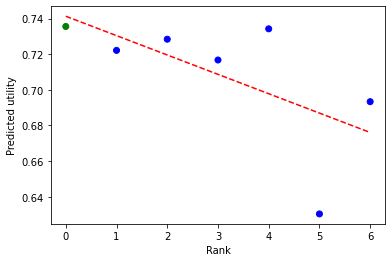

source             Tom und Maria sind erfahrene Esperantisten, de...
target             Tom and Mary are experienced Esperantists who ...
hypotheses         [Tom and Mary know that Esperantoists can be t...
utilities          [[0.6, 0.47619047619047616, 0.6, 0.5, 0.526315...
utilities_count    [79, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
count              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 1688, dtype: object


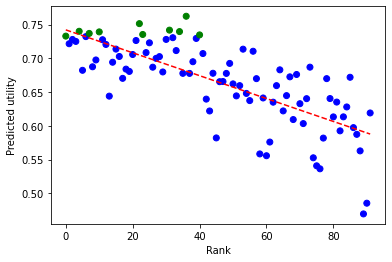

source                                     Der Reifen verliert Luft.
target                                           The tire leaks air.
hypotheses         [The tire is losing air., The tire is taking l...
utilities          [[1.0, 0.6666666666666666, 0.7272727272727272,...
utilities_count    [859, 1, 11, 9, 2, 1, 1, 1, 1, 1, 19, 1, 2, 2,...
count              [84, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]
Name: 1667, dtype: object


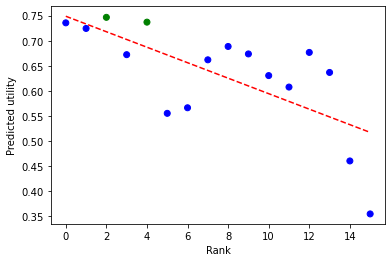

source             Der Arzt benutzte einen Zungenspatel, um den H...
target             The doctor used a tongue depressor to examine ...
hypotheses         [The doctor used a tongue but greater to see t...
utilities          [[0.5384615384615384, 0.6428571428571429, 0.61...
utilities_count    [1, 1, 39, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
count              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 968, dtype: object


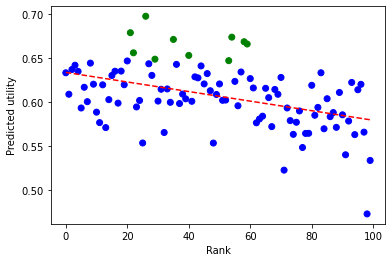

source             Ich imitierte zum ersten Mal den Lehrer und br...
target             It was the first time I mimed the teacher and ...
hypotheses         [I factories the teacher and lost all the time...
utilities          [[0.5185185185185186, 0.4666666666666666, 0.69...
utilities_count    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
count              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 2304, dtype: object


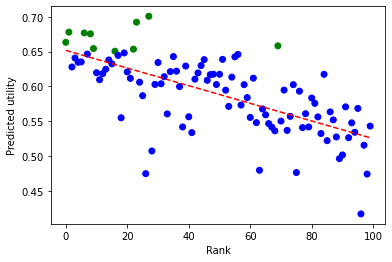

source             Menschliche Sprache vermag unendlich viele Sät...
target             Human language is capable of forming an infini...
hypotheses         [Joist language created stoness of sentences.,...
utilities          [[0.15384615384615383, 0.3157894736842105, 0.4...
utilities_count    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
count              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 789, dtype: object


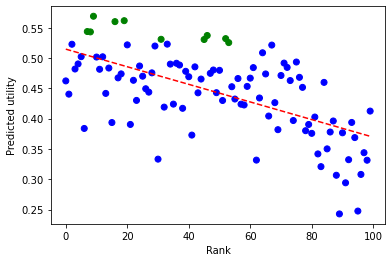

source             Was haben ein Rabe und ein Schreibtisch gemein...
target                           Why is a raven like a writing desk?
hypotheses         [What do a ravens and a desk together?, What d...
utilities          [[0.6666666666666665, 0.7777777777777777, 0.52...
utilities_count    [1, 1, 1, 1, 1, 1, 1, 1, 2, 11, 1, 1, 3, 1, 1,...
count              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 1738, dtype: object


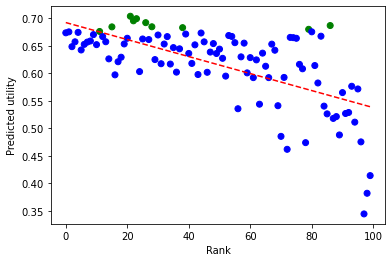

source                                   Ich war's nicht, Kommissar!
target                                   It wasn't me, commissioner!
hypotheses         [It was not me,▁festgenommenatorische!, I wasn...
utilities          [[0.15384615384615383, 0.6153846153846153, 0.6...
utilities_count    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
count              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 1705, dtype: object


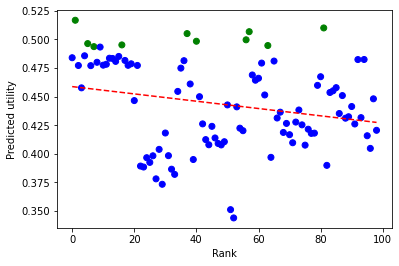

source                     Beeil dich — sonst verpassen wir den Zug!
target                             Hurry up or we'll miss the train!
hypotheses         [Hurry up, or we'll miss the train., Hurry up ...
utilities          [[0.8421052631578948, 0.8888888888888888, 0.94...
utilities_count    [3, 245, 52, 1, 18, 305, 28, 21, 1, 17, 4, 14,...
count              [30, 3, 20, 3, 1, 10, 7, 1, 4, 1, 2, 1, 1, 2, ...
Name: 1143, dtype: object


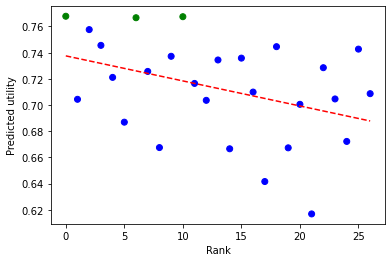

source                   Oh, es ist sehr nett von dir, das zu sagen.
target                          Oh, it's very kind of you to say so.
hypotheses         [Oh, it's very kind of you to say that., Oh, i...
utilities          [[0.7826086956521738, 1.0, 0.9090909090909091,...
utilities_count    [35, 220, 274, 123, 152, 18, 2, 1, 1, 1, 11, 1...
count              [25, 1, 4, 28, 13, 10, 3, 1, 1, 1, 1, 1, 2, 1,...
Name: 1684, dtype: object


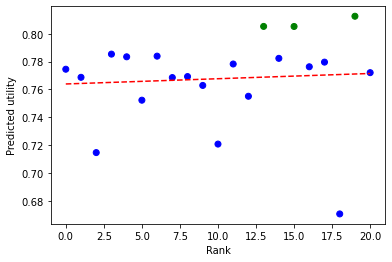

source                                    Wie lang ist diese Brücke?
target                                      How long is this bridge?
hypotheses         [How long is this bridge?, How long is that br...
utilities          [[1.0, 0.8333333333333334, 0.4615384615384615,...
utilities_count    [501, 312, 89, 1, 1, 46, 2, 5, 1, 1, 1, 1, 1, ...
count                                  [55, 32, 6, 2, 1, 1, 1, 1, 1]
Name: 1964, dtype: object


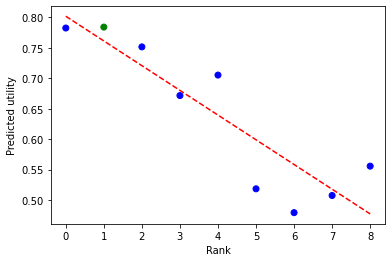

source                     Ich weiß nicht, wie lange es halten wird.
target                             I don't know how long it'll last.
hypotheses         [I don't know how long it will last., I don't ...
utilities          [[0.7368421052631577, 1.0, 0.823529411764706, ...
utilities_count    [1, 593, 256, 1, 1, 18, 66, 4, 5, 3, 1, 2, 3, ...
count                            [59, 8, 24, 1, 1, 1, 1, 1, 1, 2, 1]
Name: 1447, dtype: object


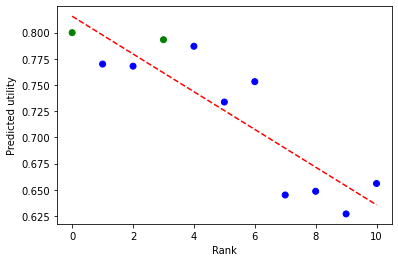

source                      Kenia war einmal eine britische Kolonie.
target                            Kenya used to be a British colony.
hypotheses         [Scout was once a British각., OM was once a Bri...
utilities          [[0.6153846153846153, 0.5, 0.6666666666666666,...
utilities_count    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
count              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 2446, dtype: object


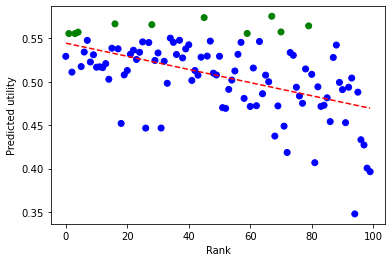

source                            Was sitzt denn da für ein Mädchen?
target                           Who's that girl sitting over there?
hypotheses         [What's that sitting for a girl?, What kind of...
utilities          [[0.5333333333333333, 0.375, 0.266666666666666...
utilities_count    [2, 7, 2, 1, 33, 1, 2, 27, 1, 4, 2, 27, 168, 1...
count              [5, 2, 17, 1, 4, 1, 2, 2, 5, 6, 1, 1, 1, 2, 1,...
Name: 337, dtype: object


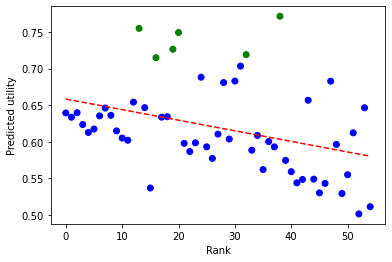

source               Tom und Maria sind beides sehr tüchtige Lehrer.
target                Tom and Mary are both very competent teachers.
hypotheses         [Tom and Mary both work very hard., Tom and Ma...
utilities          [[0.7058823529411765, 0.625, 0.705882352941176...
utilities_count    [2, 1, 1, 11, 1, 1, 1, 2, 1, 1, 1, 5, 1, 1, 1,...
count              [1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 1498, dtype: object


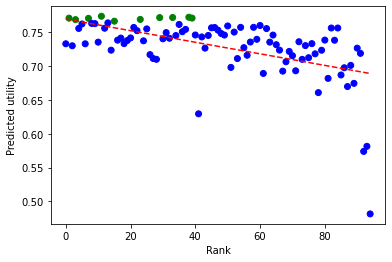

source                        Ich hoffe, dass Tom nie dahinterkommt.
target                                   I hope Tom never finds out.
hypotheses         [I hope Tom will never find out., I hope Tom n...
utilities          [[0.75, 0.7999999999999999, 0.7142857142857143...
utilities_count    [1, 687, 1, 11, 35, 48, 34, 62, 4, 2, 5, 2, 1,...
count              [7, 2, 73, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
Name: 834, dtype: object


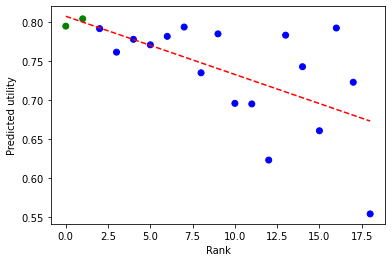

source                                   Ich hoffe, es geht ihr gut.
target                                           I hope she is okay.
hypotheses         [I hope she's okay., I hope she's all right., ...
utilities          [[1.0, 0.7272727272727272, 0.7272727272727272,...
utilities_count    [563, 185, 11, 25, 77, 1, 40, 2, 1, 6, 2, 1, 1...
count                      [54, 19, 7, 1, 1, 3, 7, 3, 1, 1, 1, 1, 1]
Name: 2306, dtype: object


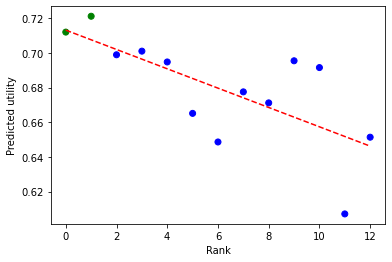

source                         Die Reise ist wichtiger als das Ziel.
target             The journey is more important than the destina...
hypotheses         [The trip is more important than the target., ...
utilities          [[0.7777777777777778, 0.8888888888888888, 0.88...
utilities_count    [1, 149, 1, 47, 1, 4, 1, 44, 1, 1, 1, 1, 1, 1,...
count              [5, 1, 7, 6, 5, 14, 1, 1, 8, 1, 1, 1, 1, 1, 1,...
Name: 641, dtype: object


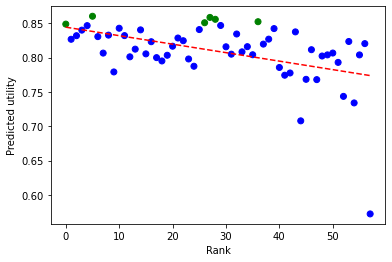

source                 Tom weiß genau, was für ein Mensch Maria ist.
target                Tom knows exactly what kind of person Mary is.
hypotheses         [Tom knows exactly what kind of person Mary is...
utilities          [[0.9, 0.9, 1.0, 0.9523809523809523, 0.9523809...
utilities_count    [1, 38, 842, 1, 17, 1, 28, 4, 5, 5, 1, 1, 1, 3...
count                    [82, 4, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1]
Name: 858, dtype: object


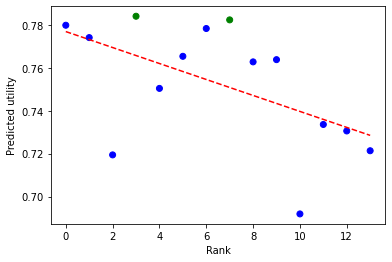

source                           Maria hat es für ihre Kinder getan.
target                                 Mary did it for her children.
hypotheses         [Mary did that for her children., Mary did it ...
utilities          [[0.8571428571428571, 0.7142857142857143, 1.0,...
utilities_count    [892, 25, 10, 40, 1, 20, 1, 1, 2, 1, 1, 1, 1, ...
count                                         [2, 91, 1, 2, 1, 1, 2]
Name: 622, dtype: object


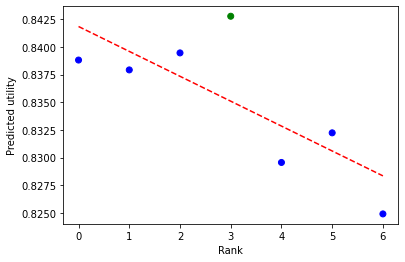

In [19]:
import matplotlib.pyplot as plt

np.random.seed(3)
indices = np.random.choice(2500, 20)
for i in indices:

    row = validation_dataset.data.iloc[i]
    print(row)
    

    predicted_means = np.array(scores[i])
    repeated_utils = get_repeated_utils(row["utilities"], row["utilities_count"])
    target_means = np.mean(repeated_utils, axis=-1)
    

    
    
    sorted_indices = np.argsort(target_means)[::-1]

    predicted_means_sorted = predicted_means[sorted_indices]
    x = np.arange(0, len(predicted_means_sorted))

    sorted_indices_predicted = np.argsort(predicted_means_sorted)[::-1]

    colors = ["b"]  * len(predicted_means)

    top_10 = math.ceil(0.1 * len(sorted_indices_predicted)) 
    for j in range(top_10):
        c = sorted_indices_predicted[j]
        colors[c] = 'g'



    z = np.polyfit(x, predicted_means_sorted, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")






    plt.scatter(x, predicted_means_sorted, marker='o', c= colors,)
    plt.xlabel('Rank')
    plt.ylabel("Predicted utility")
    #plt.title("Rank vs predicted utility for {}".format(name))


    plt.show()

In [ ]:
        
img_path_str =  path + 'training_imgs/'
img_path = Path(img_path_str)
img_path.mkdir(parents=True, exist_ok=True)
compare_random_samples(dataset_train.data, wrapped_model, model_name, path=img_path)
        
    


In [ ]:
### Next up we want to compute the MSE

# First we get the data mean of each hypothesis


# Then we get the predicted mean

all_mbr_scores = []
all_predicted_scores = []

for row in tqdm(validation_dataset.data.iterrows(), total=2500):
    i = row[0]
    entry = row[1]
        
    mbr_scores = calculate_mbr_scores(entry)

    s = all_samples[i]
    
    predicted_scores = np.mean(s, axis=1)
    all_mbr_scores.append(mbr_scores)
    all_predicted_scores.append(predicted_scores)







In [ ]:
# Next we are going to calculate the mean squared error
differences = []
c = 0
all_predicted_scores_flattened = []
all_mbr_scores_flattened = []
for target, predicted in zip(all_mbr_scores, all_predicted_scores):
    c += 1
    
    t = np.array(target)
    p = np.array(predicted).flatten()
    all_predicted_scores_flattened += p.tolist()
    all_mbr_scores_flattened += t.tolist()

    differences.append((t - p).tolist())
    
    



In [ ]:


squared_errors = []



for diff_list in differences:    
    squared_errors.append(np.array(diff_list)**2)
    

    


flattened_squared_errors = []
for e in squared_errors:
    flattened_squared_errors += list(e)


flattened_squared_errors = []
for e in squared_errors:
    flattened_squared_errors += list(e)

print(np.mean(flattened_squared_errors))

print(np.max(flattened_squared_errors))

In [ ]:
def compare_mse(squared_errors, mbr_scores, predicted_scores, path, model_name, seed=1, remove_high_values=True):
    np.random.seed(seed)
    target_best_errors = []
    predicted_best_errors = []
    flattened_squared_errors = []
    for e in squared_errors:
        flattened_squared_errors += list(e)
    # Next we get the error of the top pick compared to predicted one
    for target, predicted, errors in zip(all_mbr_scores, all_predicted_scores, squared_errors):
        best_target_index = np.argmax(target)
        best_predicted_index = np.argmax(predicted)
        target_best_errors.append(errors[best_target_index])
        predicted_best_errors.append(errors[best_predicted_index])
    
    data = {
        "squared_error": [],
        "type": [], #either all, best_target, best_predicted
    }

    flattened_squared_errors = np.random.choice(flattened_squared_errors, 2500).tolist()


    
    data["squared_error"] += flattened_squared_errors
    data["type"] += ["all"] *len(flattened_squared_errors)
     
    
   
    data["squared_error"] += target_best_errors
    data["type"] += ["best MC"] *len(target_best_errors)
    
 
    data["squared_error"] += predicted_best_errors
    data["type"] += ["best predicted"] *len(predicted_best_errors)
   
    
    df = pd.DataFrame.from_dict(data)

    g = sns.displot(df, x='squared_error', row='type', facet_kws=dict(margin_titles=True), )
    title = '{}: MSE errors'.format(model_name)

    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(title)

    def specs(x, **kwargs):
        avg = x.mean()
        plt.axvline(avg, c="red", alpha=0.5, linestyle='--', label="mean: {}".format(round(avg, 2)))

     
    g.map(specs, 'squared_error')
    
    fig = g.fig
    name = "squared_errors.png"
    save_file = str(path) + name 
    fig.savefig(save_file) 
    
    
compare_mse(squared_errors, all_mbr_scores, all_predicted_scores, path, model_name)

In [ ]:
### We also plot the distribution of the best predictions found.

def compare_best_utilities(mbr_scores, predicted_scores, path, model_name):
    
    target_best = []
    predicted_best = []
    
    best_target_index_predicted_util = []
    
    best_predicted_index_mc_util = []
    
  
    for target, predicted, in zip(mbr_scores, predicted_scores):
        best_target_index = np.argmax(target)
        best_predicted_index = np.argmax(predicted)
        target_best.append(target[best_target_index].item())
        predicted_best.append(predicted[best_predicted_index].item())
        best_target_index_predicted_util.append(predicted[best_target_index].item())
        best_predicted_index_mc_util.append(target[best_predicted_index].item())
    
    data = {
        "utility": [],
        "type": [], #either all, best_target, best_predicted
    }
    

    
  
    data["utility"] += target_best
    data["type"] += ["index: mc, util: mc"] *len(target_best)
    
    data["utility"] += predicted_best
    data["type"] += ["index: Predictive, util: predictive"] *len(predicted_best)
    
#     data["utility"] += best_target_index_predicted_util
#     data["type"] += ["index: MC, util: prediction"] *len(predicted_best)
    
#     data["utility"] += best_predicted_index_mc_util
#     data["type"] += ["index: prediction, util: MC"] *len(predicted_best)
    
    
    df = pd.DataFrame.from_dict(data)
    
    g = sns.displot(df, x='utility', row='type', facet_kws=dict(margin_titles=True), )
    title = '{}: Distribution of utility'.format(model_name)
    
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(title)

    def specs(x, **kwargs):
        plt.axvline(x.mean(), c="red", alpha=0.5, linestyle='--')
        
    g.map(specs, 'utility')
        
    fig = g.fig
    name = "utility_dist.png"
    save_file = str(path) + name 
    fig.savefig(save_file) 
    
compare_best_utilities(all_mbr_scores, all_predicted_scores, path, model_name)